# Aspen Community Clustering Project

This notebook documents the development and evaluation process of a clustering algorithm with the goal of confidently classifying a GitHub project into a 'stage of maturity'.

Current focus areas: 

* Expanding feature set
* Identifying important features 
* Identifying optimal number of clusters

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import preprocessing as pp
import json
import sqlalchemy as salc
from google.colab import drive
import pandas as pd
from time import gmtime
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import plotly.express as px
from sklearn.decomposition import PCA
from statistics import mean 
import datetime
import seaborn as sns

In [2]:
#Linking to Gdrive 
drive.mount('/content/drive', force_remount=True)

#change your folder path (where you want your files to be saved to or pulled from) 
%cd /content/drive/MyDrive/Aspen Research

Mounted at /content/drive
/content/drive/MyDrive/Aspen Research


In [3]:
with open("copy_cage-padres.json") as config_file: # MS changed path from ../comm_cage.json
    config = json.load(config_file)

In [4]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Feature Engineering
Augur Schema : https://oss-augur.readthedocs.io/en/main/schema/overview.html

In [51]:
# Query to retrieve basic repository information
basic_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT 
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated, 
              r.committers_count as committers,
              r.commit_count as commits,
              CASE WHEN r.committers_count > 0 THEN r.commit_count / r.committers_count ELSE 0 END AS commits_per_committer,
              r.pull_requests_open as prs_open,
              r.pull_requests_closed as prs_closed,
              r.pull_requests_merged as prs_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count as forks,
              r.license_file as license, 
              r.code_of_conduct_file as coc, 
              r.stars_count as stars,
              r.watchers_count as watchers, 
              r.issues_enabled
          FROM repo_groups a
          JOIN repo b ON a.repo_group_id = b.repo_group_id
          JOIN repo_info r ON r.repo_id = b.repo_id AND r.repo_info_id = (
              SELECT MAX(r2.repo_info_id)
              FROM repo_info r2
              WHERE r2.repo_id = b.repo_id
          )
""")
basic_results = pd.read_sql_query(basic_query, con=engine)

# Query to retrieve derived repository metrics
derived_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT
                 b.repo_id,
                 (SELECT AVG(c.cmt_added) FROM commits c WHERE c.repo_id = b.repo_id) AS avg_commit_length,
                 (SELECT AVG(i.comment_count) FROM issues i WHERE i.repo_id = b.repo_id) AS avg_i_comment_count,
                 AVG(DATE_PART('hour',pr.pr_closed_at - pr.pr_created_at)) as avg_time_to_close,
                 AVG(DATE_PART('hour',pr.pr_merged_at - pr.pr_created_at)) as avg_time_to_merge,
                 (SELECT AVG(commit_count) AS avg_commits_per_pr
                  FROM (SELECT pr.pull_request_id, COUNT(prc.pr_cmt_id) AS commit_count
                        FROM pull_request_commits prc
                        JOIN pull_requests pr ON prc.pull_request_id = pr.pull_request_id
                        WHERE pr.repo_id = b.repo_id
                        GROUP BY pr.pull_request_id
                       ) AS pr_commits
                 ) AS avg_commits_per_pr
          FROM repo b
          LEFT JOIN pull_requests pr ON pr.repo_id = b.repo_id
          GROUP BY b.repo_id
""")
derived_results = pd.read_sql_query(derived_query, con=engine)

# Join the results of the queries to create the final 'repos' dataframe
repos = basic_results.merge(derived_results, on='repo_id')
repos = repos.fillna(0) # change NaN values to 0
display(repos)
repos.dtypes

rg_name  repo_group_id                repo_name  \
0      Issue oss-aspen issue 269            222  vscode-kubernetes-tools   
1      Issue oss-aspen issue 269            222          deployments-k8s   
2                         coreos          25458       systemd-deprecated   
3      Issue oss-aspen issue 269            222     opendatahub-operator   
4      Issue oss-aspen issue 269            222    opendatahub-community   
...                          ...            ...                      ...   
13753  Issue oss-aspen issue 269            222              nats-server   
13754  Issue oss-aspen issue 269            222               python-tuf   
13755  Issue oss-aspen issue 269            222     opentelemetry-dotnet   
13756  Issue oss-aspen issue 269            222                community   
13757  Issue oss-aspen issue 269            222  opentelemetry-collector   

       repo_id        last_updated  committers  commits  \
0        64781 2023-03-09 09:02:25          77    593.0   
1        64789 2023-02-22 02:50:32          20      0.0   
2        27872 2023-01-28 15:57:52         321  20232.0   
3        64791 2023-02-23 14:30:33          42    234.0   
4        64793 2023-03-07 11:37:49           8     43.0   
...        ...                 ...         ...      ...   
13753    64764 2023-03-14 18:42:33         115      0.0   
13754    64777 2023-03-12 11:45:13          73      0.0   
13755    63947 2023-03-14 19:34:52         132      0.0   
13756    62344 2023-03-10 14:21:39         133      0.0   
13757    63950 2023-03-14 10:40:40         334      0.0   

       commits_per_committer  prs_open  prs_closed  ...  \
0                        7.0         8          38  ...   
1                        0.0        19          63  ...   
2                       63.0         0           3  ...   
3                        5.0         6          22  ...   
4                        5.0         3           3  ...   
...                      ...       ...         ...  ...   
13753                    0.0        23         189  ...   
13754                    0.0        11         318  ...   
13755                    0.0        18         426  ...   
13756                    0.0        14          76  ...   
13757                    0.0        27        1019  ...   

                                              license  \
0      http://choosealicense.com/licenses/apache-2.0/   
1      http://choosealicense.com/licenses/apache-2.0/   
2         http://choosealicense.com/licenses/gpl-2.0/   
3      http://choosealicense.com/licenses/apache-2.0/   
4         http://choosealicense.com/licenses/gpl-3.0/   
...                                               ...   
13753  http://choosealicense.com/licenses/apache-2.0/   
13754  http://choosealicense.com/licenses/apache-2.0/   
13755  http://choosealicense.com/licenses/apache-2.0/   
13756  http://choosealicense.com/licenses/apache-2.0/   
13757  http://choosealicense.com/licenses/apache-2.0/   

                                                     coc  stars  watchers  \
0      https://github.com/vscode-kubernetes-tools/vsc...    584        28   
1                                                      0     25         3   
2                                                      0      6        26   
3                                                      0     33         8   
4      https://github.com/opendatahub-io/opendatahub-...     17         9   
...                                                  ...    ...       ...   
13753  https://github.com/nats-io/nats-server/blob/ma...  12424       385   
13754  https://github.com/theupdateframework/python-t...   1487        44   
13755  https://github.com/open-telemetry/.github/blob...   2295        72   
13756  https://github.com/tektoncd/community/blob/mai...    289        26   
13757  https://github.com/open-telemetry/.github/blob...   2782        79   

      issues_enabled avg_commit_length  avg_i_comment_count  \
0               true 

rg_name                          object
repo_group_id                     int64
repo_name                        object
repo_id                           int64
last_updated             datetime64[ns]
committers                        int64
commits                         float64
commits_per_committer           float64
prs_open                          int64
prs_closed                        int64
prs_merged                        int64
open_issues                       int64
issues_closed                     int64
forks                             int64
license                          object
coc                              object
stars                             int64
watchers                          int64
issues_enabled                   object
avg_commit_length               float64
avg_i_comment_count             float64
avg_time_to_close               float64
avg_time_to_merge               float64
avg_commits_per_pr              float64
dtype: object

In [52]:
# issues_enabled object to bool int
repos.loc[repos.issues_enabled == 'true', 'issues_enabled'] = 1
repos.loc[repos.issues_enabled == 'false', 'issues_enabled'] = 0
repos.issues_enabled = repos.issues_enabled.astype(int)

In [53]:
# days since last update
now = datetime.datetime.now()
repos.last_updated.apply(lambda d: pd.to_datetime(str(d)))
repos.last_updated = (now - repos.last_updated).astype('timedelta64[D]')
repos.last_updated = repos.last_updated.astype(int)

In [54]:
# object to binary int for licence and coc
repos.loc[repos.license != 0, 'license'] = 1
repos.loc[repos.coc != 0, 'coc'] = 1

repos.license = repos.license.astype(int)
repos.coc = repos.coc.astype(int)

## Current Working Dataset

* Features (for each repo):

      General:
       # committers
       # commits 
       # commits/#committers 
       # prs open
       # prs closed 
       # prs merged 
       # issues open 
       # issues closed
       avg length of commit 
       # commits per pr

      Interest:
       # forks 
       # stars
       # watchers 

      Open-source(ness):
       ease of contribution score (0-3) 
            - license, code of conduct, issues enabled 
              (sum of binary features)

      Maintainer responsiveness:
       avg #comments per issue
       avg time to close (pr)
       avg time to merge (pr)

      Project velocity: 
       # days since last update
 
* Current total # of features: 18


In [27]:
repo_set = []
repo_set = np.array([repos.committers, repos.commits, repos.commits_per_committer, repos.prs_open, 
                     repos.prs_closed, repos.prs_merged, repos.open_issues, repos.issues_closed, 
                     repos.forks, repos.stars, repos.watchers, repos.last_updated, 
                     (repos.license + repos.coc + repos.issues_enabled), repos.avg_commit_length, 
                     repos.avg_i_comment_count, repos.avg_time_to_close, repos.avg_time_to_merge, 
                     repos.avg_commits_per_pr]).astype(np.int64).transpose()

In [28]:
# norm (unit var and zero mean)
scaler = pp.StandardScaler().fit(repo_set)
repo_set = scaler.transform(repo_set)

In [29]:
df_repo_set = pd.DataFrame(repo_set, columns = ["committers","commits","commits_per_commiters","prs_open",
                 "prs_closed", "prs_merged", "issues_open","issues_closed", "forks", "starts", "watchers", 
                 "last_updated", "ease_of_contr", "avg_commit_length","avg_i_comment_count", "pr_time_to_close", 
                 "pr_time_to_merge", "avg_commits_per_pr"])
df_repo_set.head()

committers   commits  commits_per_commiters  prs_open  prs_closed  \
0    0.779076 -0.048957              -0.028804  0.167378   -0.022944   
1   -0.136582 -0.077915              -0.031541  0.612571    0.022486   
2    4.698734  0.910065              -0.006907 -0.156399   -0.086546   
3    0.216830 -0.066488              -0.029586  0.086433   -0.052019   
4   -0.329352 -0.075815              -0.029586 -0.034983   -0.086546   

   prs_merged  issues_open  issues_closed     forks    starts  watchers  \
0    0.242670     2.421980       0.403863  0.160286  0.141249  0.012813   
1    6.657391     0.377287       0.073631 -0.076985 -0.085394 -0.202437   
2   -0.133460    -0.131291      -0.099969 -0.098023 -0.093098 -0.004407   
3   -0.085360     0.148946       0.013589 -0.075816 -0.082151 -0.159387   
4   -0.123998    -0.100154      -0.097359 -0.083998 -0.088638 -0.150777   

   last_updated  ease_of_contr  avg_commit_length  avg_i_comment_count  \
0     -0.650381       1.561192          -0.170478             1.062046   
1     -0.629790       0.290102          -0.166168             1.062046   
2     -0.595472      -0.980988          -0.138152            -0.385653   
3     -0.631163       0.290102          -0.170478             0.096913   
4     -0.647636       1.561192          -0.170478             0.096913   

   pr_time_to_close  pr_time_to_merge  avg_commits_per_pr  
0          1.128847          1.319376            0.110168  
1         -0.995500         -0.889162           -0.105252  
2          1.128847         -0.889162            4.418561  
3          0.916412          1.319376            0.541007  
4          2.403455          2.423645            0.110168

In [30]:
# save data to drive
df_repo_set.to_csv('/features.csv', index=False)

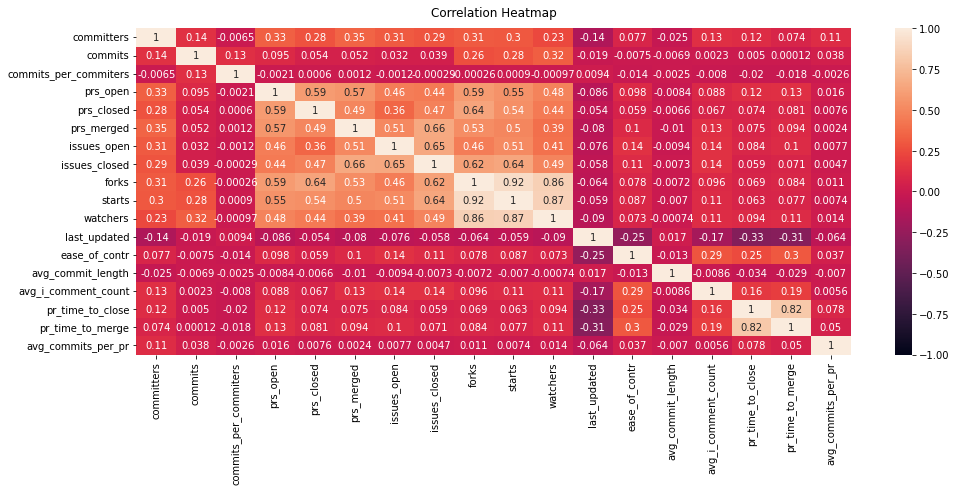

In [31]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_repo_set.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Identifying Optimal number of Clusters 

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

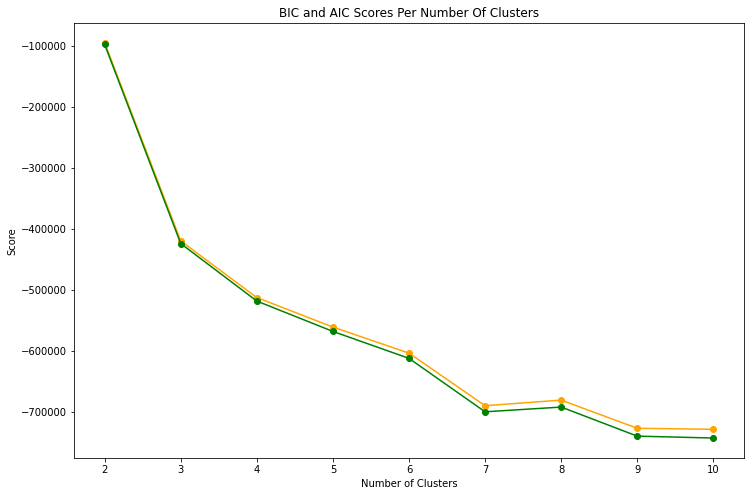

In [32]:
# cluster numbers to try
n_range = range(2,11)

bic_score = [] # Bayesian information criterion
aic_score = [] # Akaike information criterion

for n in n_range:
    gmm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gmm.fit(repo_set)
    
    bic_score.append(gmm.bic(repo_set))
    aic_score.append(gmm.aic(repo_set))
    
# Plot the BIC and AIC 
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

## Scatter Matrix of GMM predictions

Gaussian Mixture Model: [scikit-learn documentation](https://scikit-learn.org/stable/modules/mixture.html)

In [33]:
gmm = GaussianMixture(n_components=4).fit(df_repo_set)
groups = gmm.predict(df_repo_set)

fig = px.scatter_matrix(df_repo_set, title = "GMM predictions with 4 Categories",
            width=1800, height=1800, color=groups)
fig.show()

## Principal component analysis (PCA)

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space to allow us to visualize all 6 dimensions on one plot. 

In [34]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_repo_set)

fig = px.scatter(components, color=groups, title = "GMM predictions with 4 Categories")
fig.show()

In [35]:
pca = PCA(n_components=3)
components = pca.fit_transform(df_repo_set)
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(components,x=0, y=1, z=2, color=groups,title=f'Total Explained Variance: {total_var:.2f}%')
fig.show()

## Magnitude of each feature value

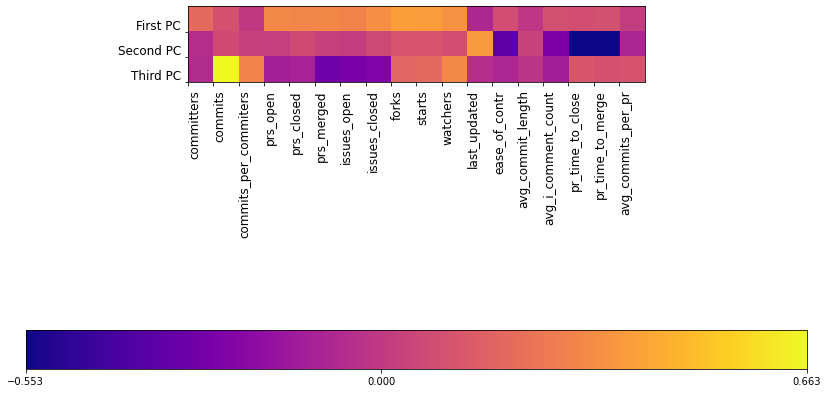

In [43]:
fig = plt.figure(figsize=(14, 7))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')

plt.gca().set_xticks(np.arange(-.5, len(df_repo_set.columns)-1));
plt.gca().set_yticks(np.arange(0.5, 3));
plt.gca().set_xticklabels(df_repo_set.columns, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC', 'Third PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()], pad=0.65);

## Cluster statistics

In [45]:
for color in range(max(groups)+1):
  print("\nCluster #",color)
  c = np.where(groups == color)
  print("Repo count:", len(c[0]))
  print("Cluster statistics:")
  display(repos.iloc[c[0]].describe())
  print("\nRepo examples:")
  for i, y in enumerate(c[0]):
    print(repos.iloc[y].rg_name,":",repos.iloc[y].repo_name)
    if i == 10:
      break


Cluster # 0
Repo count: 9310
Cluster statistics:


repo_group_id       repo_id  last_updated   committers       commits  \
count    9310.000000   9310.000000   9310.000000  9310.000000  9.310000e+03   
mean    40649.821697  37233.010419    648.239098    18.892052  1.406590e+03   
std     30032.603485  13095.098994    814.152139    50.195384  2.129358e+04   
min        10.000000  25430.000000      1.000000     0.000000  0.000000e+00   
25%     25478.000000  28684.250000     54.000000     2.000000  2.000000e+00   
50%     25536.000000  32210.000000    295.000000     4.000000  3.200000e+01   
75%     25630.000000  35535.750000    881.000000    10.000000  1.720000e+02   
max    100147.000000  64901.000000   3732.000000   443.000000  1.155636e+06   

       commits_per_committer     prs_open   prs_closed   prs_merged  \
count            9310.000000  9310.000000  9310.000000  9310.000000   
mean              102.799356     0.398604     1.322771     7.883136   
std              3105.921531     1.022981     2.905262    17.361730   
min                 0.000000     0.000000     0.000000     0.000000   
25%                 1.000000     0.000000     0.000000     0.000000   
50%                 7.000000     0.000000     0.000000     0.000000   
75%                20.000000     0.000000     1.000000     6.000000   
max            185541.000000    18.000000    32.000000   146.000000   

       open_issues  ...      license          coc        stars     watchers  \
count  9310.000000  ...  9310.000000  9310.000000  9310.000000  9310.000000   
mean      0.460258  ...     0.708915     0.289366     6.201396    10.671858   
std       1.387481  ...     0.454287     0.453493    14.432002    15.505084   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.000000  ...     0.000000     0.000000     0.000000     3.000000   
50%       0.000000  ...     1.000000     0.000000     1.000000     6.000000   
75%       0.000000  ...     1.000000     1.000000     6.000000    12.000000   
max      40.000000  ...     1.000000     1.000000   561.000000   333.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count     9310.000000        9310.000000          9310.000000   
mean         0.595811          91.397336             0.351320   
std          0.490761         560.611812             0.900967   
min          0.000000           0.000000             0.000000   
25%          0.000000          14.189112             0.000000   
50%          1.000000          25.516729             0.000000   
75%          1.000000          56.953888             0.000000   
max          1.000000       27418.600000            17.000000   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count        9310.000000        9310.000000         9310.000000  
mean            3.769428           3.070856            1.931593  
std             5.122470           4.732439           10.791413  
min             0.000000           0.000000            0.000000  
25%             0.000000           0.000000            0.000000  
50%             0.000000           0.000000            0.000000  
75%             7.000000           5.750000            1.500000  
max            23.000000          23.000000          250.000000  

[8 rows x 22 columns]


Repo examples:
coreos : systemd-deprecated
Issue oss-aspen issue 269 : opendatahub-community
gitGNU : gnu_gnuastro
openstack : oslo.context
grafana : icons
gitGNU : gnu_artanis
Anaconda-Platform : python-flatbuffers-feedstock
arquillian : arquillian-extension-android
gitGNU : gnu_pigreco
eclipse : titan.ProtocolModules.RADIUS_ProtocolModule_Generator
gitGNU : gnu_gphpedit

Cluster # 1
Repo count: 4441
Cluster statistics:


repo_group_id       repo_id  last_updated   committers        commits  \
count    4441.000000   4441.000000   4441.000000  4441.000000    4441.000000   
mean    44040.236433  39918.196127    124.283044    48.185544    1690.020491   
std     33366.462077  14641.193951    261.521657    77.318749    6749.119562   
min        10.000000  25431.000000      0.000000     0.000000       0.000000   
25%     25478.000000  29279.000000     26.000000     9.000000       0.000000   
50%     25536.000000  32656.000000     45.000000    19.000000     134.000000   
75%    100002.000000  61139.000000     89.000000    46.000000     723.000000   
max    100147.000000  64899.000000   3319.000000   466.000000  115051.000000   

       commits_per_committer     prs_open    prs_closed    prs_merged  \
count            4441.000000  4441.000000   4441.000000   4441.000000   
mean               34.271560    10.488404    130.035127    479.133754   
std               198.380259    38.865504    568.072738   1773.383526   
min                 0.000000     0.000000      0.000000      0.000000   
25%                 0.000000     0.000000      7.000000     26.000000   
50%                 9.000000     3.000000     23.000000    104.000000   
75%                28.000000     8.000000     72.000000    311.000000   
max             10391.000000  1012.000000  13676.000000  48161.000000   

       open_issues  ...      license          coc         stars     watchers  \
count  4441.000000  ...  4441.000000  4441.000000   4441.000000  4441.000000   
mean     35.724837  ...     0.845755     0.494483    591.785184    54.360279   
std     143.185987  ...     0.361224     0.500026   2639.638068   125.065694   
min       0.000000  ...     0.000000     0.000000      0.000000     0.000000   
25%       0.000000  ...     1.000000     0.000000     10.000000    10.000000   
50%       4.000000  ...     1.000000     0.000000     45.000000    19.000000   
75%      20.000000  ...     1.000000     1.000000    199.000000    42.000000   
max    3957.000000  ...     1.000000     1.000000  54030.000000  3088.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count     4441.000000        4441.000000          4441.000000   
mean         0.803197          54.861981             2.220967   
std          0.397627          85.915629             3.238500   
min          0.000000           0.000000             0.000000   
25%          1.000000          15.582188             0.100000   
50%          1.000000          26.299613             1.761905   
75%          1.000000          60.769560             3.250000   
max          1.000000        1647.793222           132.000000   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count        4441.000000        4441.000000         4441.000000  
mean            7.447491           6.796546            2.721922  
std             2.879429           3.336089            4.924318  
min             0.000000           0.000000            0.000000  
25%             5.916667           4.971047            1.188119  
50%             7.902597           7.283747            1.843450  
75%             9.400000           9.035714            2.936599  
max            19.333333          23.000000          149.518519  

[8 rows x 22 columns]


Repo examples:
Issue oss-aspen issue 269 : vscode-kubernetes-tools
Issue oss-aspen issue 269 : deployments-k8s
Issue oss-aspen issue 269 : opendatahub-operator
Issue oss-aspen issue 269 : blackbox_exporter
Issue oss-aspen issue 269 : client_golang
Issue oss-aspen issue 269 : mysqld_exporter
Issue oss-aspen issue 269 : client_python
Issue oss-aspen issue 269 : odh-manifests
Issue oss-aspen issue 269 : odh-dashboard
Issue oss-aspen issue 269 : jmx_exporter
backube : scribe

Cluster # 2
Repo count: 6
Cluster statistics:


repo_group_id       repo_id  last_updated  committers        commits  \
count       6.000000      6.000000      6.000000    6.000000       6.000000   
mean    21276.666667  35083.500000      9.166667  376.166667   32645.666667   
std     10314.724575  14358.464246     15.753307   43.171364   44893.762599   
min       222.000000  27784.000000      1.000000  327.000000       0.000000   
25%     25456.250000  27960.250000      1.000000  347.250000       0.000000   
50%     25467.000000  28474.500000      3.000000  368.000000   17839.500000   
75%     25477.750000  32601.500000      5.750000  399.250000   43188.750000   
max     25570.000000  64002.000000     41.000000  444.000000  114503.000000   

       commits_per_committer    prs_open    prs_closed    prs_merged  \
count               6.000000    6.000000      6.000000      6.000000   
mean               90.166667  427.333333  17712.000000  28100.333333   
std               124.935850  202.598782  12736.589873  23710.080790   
min                 0.000000  212.000000   4637.000000      5.000000   
25%                 0.000000  326.500000   9023.250000   8889.250000   
50%                54.500000  372.500000  15222.000000  27248.500000   
75%               111.250000  468.750000  22280.250000  49543.000000   
max               320.000000  795.000000  39601.000000  54356.000000   

       open_issues  ...  license       coc         stars     watchers  \
count     6.000000  ...      6.0  6.000000      6.000000     6.000000   
mean   1848.833333  ...      1.0  0.666667  68386.333333  2641.000000   
std    1592.894776  ...      0.0  0.516398  23404.682221   521.651608   
min       0.000000  ...      1.0  0.000000  34878.000000  1955.000000   
25%     808.500000  ...      1.0  0.250000  58223.250000  2223.750000   
50%    1452.000000  ...      1.0  1.000000  64208.000000  2800.000000   
75%    3084.000000  ...      1.0  1.000000  86783.500000  2951.750000   
max    3967.000000  ...      1.0  1.000000  96487.000000  3257.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count        6.000000           6.000000             6.000000   
mean         0.833333          37.315506             5.626055   
std          0.408248          17.406672             3.447318   
min          0.000000          16.411998             0.000000   
25%          1.000000          24.063957             4.228543   
50%          1.000000          36.261568             6.280180   
75%          1.000000          49.768792             7.311267   
max          1.000000          60.688618             9.996343   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count           6.000000           6.000000            6.000000  
mean            9.297453           9.174044            3.788866  
std             0.922800           1.064690            2.352447  
min             7.941619           7.701619            0.000000  
25%             8.712032           8.478556            3.012962  
50%             9.480189           9.255195            4.278196  
75%            10.088923           9.823234            4.435879  
max            10.134905          10.600000            7.097147  

[8 rows x 22 columns]


Repo examples:
Issue oss-aspen issue 269 : elasticsearch
ansible : ansible-2
kubernetes : kubernetes
apache : spark
moby : moby
nodejs : node

Cluster # 3
Repo count: 1
Cluster statistics:


repo_group_id  repo_id  last_updated  committers    commits  \
count            1.0      1.0           1.0         1.0        1.0   
mean         25648.0  36109.0          41.0         0.0  1154920.0   
std              NaN      NaN           NaN         NaN        NaN   
min          25648.0  36109.0          41.0         0.0  1154920.0   
25%          25648.0  36109.0          41.0         0.0  1154920.0   
50%          25648.0  36109.0          41.0         0.0  1154920.0   
75%          25648.0  36109.0          41.0         0.0  1154920.0   
max          25648.0  36109.0          41.0         0.0  1154920.0   

       commits_per_committer  prs_open  prs_closed  prs_merged  open_issues  \
count                    1.0       1.0         1.0         1.0          1.0   
mean                     0.0     312.0       440.0         9.0          0.0   
std                      NaN       NaN         NaN         NaN          NaN   
min                      0.0     312.0       440.0         9.0          0.0   
25%                      0.0     312.0       440.0         9.0          0.0   
50%                      0.0     312.0       440.0         9.0          0.0   
75%                      0.0     312.0       440.0         9.0          0.0   
max                      0.0     312.0       440.0         9.0          0.0   

       ...  license  coc     stars  watchers  issues_enabled  \
count  ...      1.0  1.0       1.0       1.0             1.0   
mean   ...      1.0  0.0  145481.0    8135.0             0.0   
std    ...      NaN  NaN       NaN       NaN             NaN   
min    ...      1.0  0.0  145481.0    8135.0             0.0   
25%    ...      1.0  0.0  145481.0    8135.0             0.0   
50%    ...      1.0  0.0  145481.0    8135.0             0.0   
75%    ...      1.0  0.0  145481.0    8135.0             0.0   
max    ...      1.0  0.0  145481.0    8135.0             0.0   

       avg_commit_length  avg_i_comment_count  avg_time_to_close  \
count           1.000000                  1.0           1.000000   
mean           23.129546                  0.0           5.489978   
std                  NaN                  NaN                NaN   
min            23.129546                  0.0           5.489978   
25%            23.129546                  0.0           5.489978   
50%            23.129546                  0.0           5.489978   
75%            23.129546                  0.0           5.489978   
max            23.129546                  0.0           5.489978   

       avg_time_to_merge  avg_commits_per_pr  
count           1.000000                 1.0  
mean           10.444444                 0.0  
std                  NaN                 NaN  
min            10.444444                 0.0  
25%            10.444444                 0.0  
50%            10.444444                 0.0  
75%            10.444444                 0.0  
max            10.444444                 0.0  

[8 rows x 22 columns]


Repo examples:
torvalds : linux


## Sample repo query - finding nearest neighbors

Given a name and organization for a target repo, we want to be able to identify which cluster the repo belongs to and list projects that are most similar to it (based on current set of features).

In [55]:
target_repo = 'kubernetes'
target_rg = 'kubernetes'

repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT 
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated, 
              r.committers_count as committers,
              r.commit_count as commits,
              CASE WHEN r.committers_count > 0 THEN r.commit_count / r.committers_count ELSE 0 END AS commits_per_committer,
              r.pull_requests_open as prs_open,
              r.pull_requests_closed as prs_closed,
              r.pull_requests_merged as prs_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count as forks,
              r.license_file as license, 
              r.code_of_conduct_file as coc, 
              r.stars_count as stars,
              r.watchers_count as watchers, 
              r.issues_enabled,
              (SELECT AVG(c.cmt_added) FROM commits c WHERE c.repo_id = b.repo_id) AS avg_commit_length,
              (SELECT AVG(i.comment_count) FROM issues i WHERE i.repo_id = b.repo_id) AS avg_i_comment_count,
              AVG(DATE_PART('hour',pr.pr_closed_at - pr.pr_created_at)) as avg_time_to_close,
              AVG(DATE_PART('hour',pr.pr_merged_at - pr.pr_created_at)) as avg_time_to_merge,
              (SELECT AVG(commit_count) AS avg_commits_per_pr
         FROM (SELECT pr.pull_request_id, COUNT(prc.pr_cmt_id) AS commit_count
               FROM pull_request_commits prc
               JOIN pull_requests pr ON prc.pull_request_id = pr.pull_request_id
               WHERE pr.repo_id = b.repo_id
               GROUP BY pr.pull_request_id
              ) AS pr_commits
        ) AS avg_commits_per_pr
          FROM repo_groups a
          JOIN repo b ON a.repo_group_id = b.repo_group_id
          JOIN repo_info r ON r.repo_id = b.repo_id AND r.repo_info_id = (
              SELECT MAX(r2.repo_info_id)
              FROM repo_info r2
              WHERE r2.repo_id = b.repo_id
          )
          LEFT JOIN pull_requests pr ON pr.repo_id = b.repo_id
          WHERE b.repo_name = \'{target_repo}\' AND a.rg_name = \'{target_rg}\'
          GROUP BY
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated,
              r.committers_count,
              r.commit_count,
              r.pull_requests_open,
              r.pull_requests_closed,
              r.pull_requests_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count,
              r.license_file,
              r.code_of_conduct_file,
              r.stars_count,
              r.watchers_count,
              r.issues_enabled

""")
target = pd.read_sql(repo_query, con=engine)
target = target.fillna(0) # change NaN values to 0
display(target)
target.dtypes

rg_name  repo_group_id   repo_name  repo_id        last_updated  \
0  kubernetes          25457  kubernetes    27835 2023-03-09 14:30:23   

   committers  commits  commits_per_committer  prs_open  prs_closed  ...  \
0         357   114503                    320       795       18423  ...   

                                          license  \
0  http://choosealicense.com/licenses/apache-2.0/   

                                                 coc  stars  watchers  \
0  https://github.com/kubernetes/kubernetes/blob/...  96487      3257   

  issues_enabled avg_commit_length  avg_i_comment_count  avg_time_to_close  \
0           true         40.793501             9.996343           9.990877   

  avg_time_to_merge  avg_commits_per_pr  
0          9.921775            2.600306  

[1 rows x 24 columns]

rg_name                          object
repo_group_id                     int64
repo_name                        object
repo_id                           int64
last_updated             datetime64[ns]
committers                        int64
commits                           int64
commits_per_committer             int64
prs_open                          int64
prs_closed                        int64
prs_merged                        int64
open_issues                       int64
issues_closed                     int64
forks                             int64
license                          object
coc                              object
stars                             int64
watchers                          int64
issues_enabled                   object
avg_commit_length               float64
avg_i_comment_count             float64
avg_time_to_close               float64
avg_time_to_merge               float64
avg_commits_per_pr              float64
dtype: object

In [56]:
# issues_enabled object to bool int
target.loc[target.issues_enabled == 'true', 'issues_enabled'] = 1
target.loc[target.issues_enabled == 'false', 'issues_enabled'] = 0
target.issues_enabled = target.issues_enabled.astype(int)

# days since last update
now = datetime.datetime.now()
target.last_updated.apply(lambda d: pd.to_datetime(str(d)))
target.last_updated = (now - target.last_updated).astype('timedelta64[D]')
target.last_updated = target.last_updated.astype(int)

# object to binary int for licence and coc
target.loc[target.license != 0, 'license'] = 1
target.loc[target.coc != 0, 'coc'] = 1

target.license = target.license.astype(int)
target.coc = target.coc.astype(int)

target_set = []
target_set = np.array([target.committers, target.commits, target.commits_per_committer, target.prs_open, 
                     target.prs_closed, target.prs_merged, target.open_issues, target.issues_closed, 
                     target.forks, target.stars, target.watchers, target.last_updated, 
                     (target.license + target.coc + target.issues_enabled), target.avg_commit_length, 
                     target.avg_i_comment_count, target.avg_time_to_close, target.avg_time_to_merge, 
                     target.avg_commits_per_pr]).astype(np.int64).transpose()


In [57]:
# norm (unit var and zero mean)
#scaler = pp.StandardScaler().fit(repo_set)
target_set = scaler.transform(target_set)

df_target = pd.DataFrame(target_set, columns = ["committers","commits","commits_per_commiters","prs_open",
                 "prs_closed", "prs_merged", "issues_open","issues_closed", "forks", "starts", "watchers", 
                 "last_updated", "ease_of_contr", "avg_commit_length","avg_i_comment_count", "pr_time_to_close", 
                 "pr_time_to_merge", "avg_commits_per_pr"])

print(df_target)

   committers   commits  commits_per_commiters   prs_open  prs_closed  \
0    5.277044  5.513553                0.09358  32.018934   33.386127   

   prs_merged  issues_open  issues_closed      forks     starts   watchers  \
0   42.725704      16.6518      53.435479  41.278301  39.024491  27.814516   

   last_updated  ease_of_contr  avg_commit_length  avg_i_comment_count  \
0     -0.650381       1.561192          -0.084276             3.957444   

   pr_time_to_close  pr_time_to_merge  avg_commits_per_pr  
0          0.916412          1.098522            0.002458  


In [58]:
d = repo_set - target_set
distances = np.linalg.norm(d,axis = 1)

k = 10
nn_ids = distances.argsort()[:k]
print("Cluster of target repo: ",gmm.predict(df_target))
print("\nMost similar repos:")
for repo in nn_ids:
    print(repos.iloc[repo].rg_name,":",repos.iloc[repo].repo_name)

Cluster of target repo:  [2]

Most similar repos:
oracle : node-oracledb
syndesisio : syndesis-integration-runtime
Issue oss-aspen issue 269 : elasticsearch
helm : docker-kubectl-helm-az
containerssh : examples
elastic : topology-ece
GNOME : gnome-online-accounts
zanata : tmgmt_zanata
patternfly : patternfly-conference
apache : airflow
